In [2]:
import pandas as pd

from trampact.preprocess import get_data

In [3]:
!pwd

/home/primitive/code/eangelid/trampact/notebooks


In [19]:
IRIS_T1_CSV = 'iris_T1.csv'
IRIS_T2_CSV = 'iris_T2.csv'
BD_GENT_2006 = 'BD_GENT_2006.csv'
BD_GENT_2016 = 'BD_GENT_2016.csv'

In [20]:
iris_T1 = get_data(IRIS_T1_CSV, is_local_csv=True)
iris_T1.head()

/home/primitive/code/eangelid/trampact/trampact


,iris_id,NOM_IRIS
0,60881304,Saint-Sylvestre
1,60881503,Jeanne d'Arc-Fuon-Cauda
2,60881303,Gorbella
3,60881505,Michelet
4,60881302,Saint-Barthelemy


In [21]:
iris_T2 = get_data(IRIS_T2_CSV, is_local_csv=True)[['iris_id', 'NOM_IRIS']]
iris_T2.head()

/home/primitive/code/eangelid/trampact/trampact


,iris_id,NOM_IRIS
0,61230107,Centre Ville
1,61230103,Les Pomarels
2,61230102,Les Paluds
3,61230101,Le Lac
4,60883102,Parc des Sports


In [22]:
bd_gent_2006 = get_data(BD_GENT_2006, is_local_csv=True)
print(bd_gent_2006.shape)
bd_gent_2006.head()

/home/primitive/code/eangelid/trampact/trampact
(500, 45)


,iris_id,t_actifs_2006,t_chom_2006,empl_2006,ouvrier_2006,TP_2006,Int_2006,app_stage_2006,cdd_2006,rev_2006,HLM_2006,no_transp_2006,walk_2006,moto_2006,voit_2006,TC_2006,HH_2006,HH_moins_2ans_2006,HH_2_4ans_2006,HH_5_9ans_2006,HH_plus_10ans_2006,HH_with_park_2006,HH_with_voit_2006,HH_1voit_2006,HH_2voit_2006,pop_2006,tx_chom_2006,tx_empl_2006,tx_ouvr_2006,tx_TP_2006,tx_HLM_2006,tx_no_transp_2006,tx_walk_2006,tx_moto_2006,tx_voit_2006,tx_TC_2006,tx_HH_moins2ans_2006,tx_HH_2_4ans_2006,tx_HH_5_9ans_2006,tx_HH_plus10ans_2006,tx_HH_with_park_2006,tx_HH_with_voit_2006,tx_HH_1voit_2006,tx_HH_2voit_2006,tx_empl_prec_2006
0,60010000,32.377778,2.088889,8.355556,0.000000,6.266667,0.000000,0.000000,8.355556,17465.0,0.000000,4.177778,4.177778,0.000000,25.066667,4.177778,48.044444,4.177778,9.400000,7.311111,27.155556,26.111111,39.688889,24.022222,15.666667,94.000000,6.451613,25.806453,0.000000,19.354840,0.000000,12.903226,12.903226,0.000000,77.419355,12.903226,12.903226,29.032258,22.580645,83.870969,80.645160,122.580645,74.193547,48.387097,25.806453
1,60020000,12.008551,3.002138,4.002850,4.002850,1.000713,0.000000,0.973333,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,8.005701,0.000000,16.011401,3.002138,4.002850,2.001425,7.004988,8.005701,16.011401,13.009263,3.002138,26.018527,25.000002,33.333331,33.333331,8.333337,0.000000,0.000000,0.000000,0.000000,66.666669,0.000000,25.000002,33.333331,16.666665,58.333333,66.666669,133.333331,108.333328,25.000002,8.105335
2,60030000,232.021978,24.725275,51.282051,80.586081,32.967033,0.915751,3.622305,28.388278,13866.0,56.776557,22.315018,14.652015,0.000000,164.835165,0.000000,221.864469,55.945055,52.282051,48.534799,65.102564,135.531136,200.802198,130.120879,70.681319,504.000000,10.656437,22.102239,34.732089,14.208582,11.265190,9.617631,6.314925,0.000000,71.042910,0.000000,24.111964,22.533232,20.918190,28.058792,58.413059,86.544473,56.081273,30.463200,14.191041
3,60040101,558.359852,79.552998,189.506664,142.278837,104.191062,0.000000,9.724609,43.918480,20108.0,0.000000,41.480344,36.863236,17.281780,317.798566,69.518695,355.457492,19.929151,76.767940,54.191120,204.569281,269.342796,342.223655,172.229956,169.993699,1049.146740,14.247621,33.939880,25.481566,18.660199,0.000000,7.428962,6.602057,3.095097,56.916443,12.450518,3.569231,13.748829,9.705411,36.637534,48.238210,61.290878,30.845691,30.445187,9.607261
4,60040102,1322.676650,95.706717,453.856986,188.318276,203.919192,11.170277,17.151069,81.122892,18178.0,414.223503,27.683188,18.400696,78.692463,1032.707780,75.930422,999.846244,67.105704,148.040057,217.980563,566.719919,688.820649,928.903026,448.849185,480.053840,2577.408407,7.235836,34.313525,14.237665,15.417161,16.071318,2.092967,1.391171,5.949486,78.077116,5.740664,5.073478,11.192460,16.480261,42.846445,52.077781,70.229033,33.934914,36.294119,8.274451


In [23]:
bd_gent_2016 = get_data(BD_GENT_2016, is_local_csv=True)
print(bd_gent_2016.shape)
bd_gent_2016.head()

/home/primitive/code/eangelid/trampact/trampact
(500, 45)


,iris_id,t_actifs_2016,t_chom_2016,empl_2016,ouvrier_2016,TP_2016,Int_2016,app_stage_2016,CDD_2016,rev_2016,HLM_2016,no_transp_2016,walk_2016,moto_2016,voit_2016,TC_2016,HH_2016,HH_moins_2ans_2016,HH_2_4ans_2016,HH_5_9ans_2016,HH_plus_10ans_2016,HH_with_park_2016,HH_with_voit_2016,HH_1voit_2016,HH_2voit_2016,pop_2016,tx_chom_2016,tx_empl_2016,tx_ouvr_2016,tx_TP_2016,tx_HLM_2016,tx_no_transp_2016,tx_walk_2016,tx_moto_2016,tx_voit_2016,tx_TC_2016,tx_HH_moins2ans_2016,tx_HH_2_4ans_2016,tx_HH_5_9ans_2016,tx_HH_plus10ans_2016,tx_HH_with_park_2016,tx_HH_with_voit_2016,tx_HH_1voit_2016,tx_HH_2voit_2016,tx_empl_prec_2016
0,60010000,36.365591,5.741935,4.784946,0.000000,6.698925,0.000000,0.000000,1.913978,NaN,0.000000,9.569892,0.000000,0.000000,23.924731,9.569892,45.935484,10.526882,10.526882,7.655914,17.225806,26.795699,40.193548,26.795699,13.397849,89.000000,15.789474,13.157895,0.000000,18.421053,0.000000,26.315789,0.000000,0.000000,65.789474,26.315789,28.947368,28.947368,21.052632,47.368421,73.684211,110.526316,73.684211,36.842105,5.263158
1,60020000,31.146667,5.840000,4.866667,4.866667,6.813333,0.000000,0.973333,5.840000,NaN,0.000000,0.000000,0.000000,0.000000,29.200000,0.000000,37.960000,4.866667,7.786667,3.893333,21.413333,10.706667,28.226667,20.440000,7.786667,73.000000,18.750000,15.625000,15.625000,21.875000,0.000000,0.000000,0.000000,0.000000,93.750000,0.000000,15.625000,25.000000,12.500000,68.750000,34.375000,90.625000,65.625000,25.000000,21.875000
2,60030000,269.050007,43.467660,95.085507,67.918219,42.562084,1.811153,3.622305,18.111525,15670.0,59.768033,9.055763,18.111525,4.527881,221.866183,0.000000,269.955583,30.789593,63.390338,65.295349,110.480303,187.548144,252.749634,140.458178,112.291456,589.000000,16.155978,35.341202,25.243716,15.819395,10.147374,3.365829,6.731658,1.682914,82.462805,0.000000,11.443818,23.560802,24.268852,41.063111,69.707541,93.941508,52.205231,41.736277,8.751155
3,60040101,604.818909,96.239886,183.644202,102.723350,53.893508,3.788325,9.724609,40.522157,21136.0,284.838873,18.168646,24.234791,42.457636,364.970125,55.582539,630.544586,82.365854,231.907761,204.006484,112.264488,454.339815,484.418553,336.213056,148.205497,1302.147404,15.912182,30.363502,16.984150,8.910685,21.874549,3.003981,4.006950,7.019892,60.343703,9.189947,13.618267,38.343338,33.730176,18.561670,75.119975,80.093156,55.589045,24.504111,8.934094
4,60040102,1265.456645,91.799759,341.483429,157.342286,152.709438,1.142076,17.151069,81.025567,24220.0,298.156364,48.221724,17.479553,113.220079,937.451388,68.296031,1027.191612,78.869138,179.118869,107.473478,661.730126,746.399126,961.909377,495.230991,466.678386,2498.174757,7.254279,26.984996,12.433637,12.067536,11.934968,3.810618,1.381284,8.946974,74.080087,5.396948,6.232465,14.154485,8.492861,52.291805,58.982592,76.012828,39.134568,36.878260,7.848448


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
draw_feature = 'tx_voit_'
BINS=20

(array([ 5., 26., 24., 39., 41., 37., 44., 51., 71., 74., 53., 20., 10.,
         3.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 16.33263977,  22.47252955,  28.61241932,  34.7523091 ,
         40.89219888,  47.03208865,  53.17197843,  59.31186821,
         65.45175798,  71.59164776,  77.73153754,  83.87142731,
         90.01131709,  96.15120686, 102.29109664, 108.43098642,
        114.57087619, 120.71076597, 126.85065575, 132.99054552,
        139.1304353 ]),
 <BarContainer object of 20 artists>)

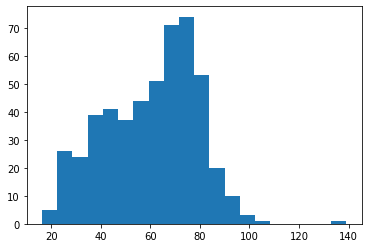

In [42]:
plt.hist(bd_gent_2006[f'{draw_feature}2006'], bins=BINS)

(array([ 2., 22., 26., 37., 37., 27., 39., 42., 56., 57., 60., 50., 27.,
         7.,  7.,  1.,  1.,  0.,  0.,  1.]),
 array([ 10.00880175,  16.03010079,  22.05139984,  28.07269888,
         34.09399792,  40.11529697,  46.13659601,  52.15789505,
         58.17919409,  64.20049314,  70.22179218,  76.24309122,
         82.26439027,  88.28568931,  94.30698835, 100.32828739,
        106.34958644, 112.37088548, 118.39218452, 124.41348357,
        130.43478261]),
 <BarContainer object of 20 artists>)

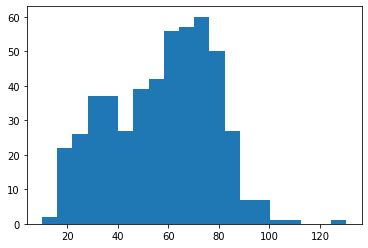

In [43]:
plt.hist(bd_gent_2016[f'{draw_feature}2016'], bins=BINS)